In [5]:
import os

# if you want to use the GPU
#device = 'gpu'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np

from PIL import Image
from theano import config
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from scipy.misc import imread

from sklearn.cluster import KMeans

from PIL import Image
from resizeimage import resizeimage

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

# import libraries for image feature extraction
import cv2

# And now we finally classify 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, precision_score

np.random.seed(1) # we initialize a random seed here to make the experiments repeatable with same results

In [6]:
print ("keras version: ",keras.__version__)
print ("PIL version: ",Image.__version__)
print ("numpy version: ",np.__version__)
print ("OpenCV version: ",cv2.__version__)

keras version:  2.2.4
PIL version:  5.4.1
numpy version:  1.16.1
OpenCV version:  4.0.0


# MLP and ML classification

### Dataset: 30 fruits image dataset 
In this subtask we decided to extract image features and compare classification of Neural Network(MLP) with classical ML classifiers. For the purpose of fruits dataset clasification we implemented 6 different feature datasets to work with.  
 - "simple-hist" - is a feature dataset containing histogram with no colors 
 - "keypoints" - is a feature dataset containing image keypoints (extracted with openCV KAZE)
 - "BOW" - is a bag of "visual" words made with image keypoints clustered with Kmeans 
 - "hist-1D" - is a feature dataset containing histogram values by looking single channel at time
 - "hist-2D" - is a feature dataset containing histogram values by looking 2 channels(combinations) at the same time
 - "hist-3D" - is a feature dataset containing histogram values by looking all 3 channels(combinations) at the same time]

In [7]:
# We need to construct our data set; unfortunately, we don't simply have a "loadFruitImageDataSet()" function in SK-learn...
# So we need to 
## Download our data set & extract it (one-time effort)
## Run an image feature extraction
## Create the create the ground truth (label assignment, target, ...) 


# path to our image folder
# For the first run, download the images from http://data.vicos.si/datasets/FIDS30/FIDS30.zip, and unzip them to your folder
imagePath = "/home/xxx/MScBI/S4/ML/exer3/data/FIDS30/"


# Find all images in that folder; there are like 1.000 different ways to do this in Python, we chose this one :-)
import glob, os
os.chdir(imagePath)
fileNames = glob.glob("*/*.jpg")
numberOfFiles=len(fileNames)
targetLabels=[]

print ("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...) 
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that
for fileName in fileNames:
    pathSepIndex = fileName.index("/")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers
print("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
target = le.transform(targetLabels); 
print("Transformed labels (first elements: " + str(target[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print list(le.inverse_transform([0, 18, 1]))

print("... done label encoding")

Found 971 files

Found the following classes: ['acerolas', 'apples', 'apricots', 'avocados', 'bananas', 'blackberries', 'blueberries', 'cantaloupes', 'cherries', 'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'kiwifruit', 'lemons', 'limes', 'mangos', 'olives', 'oranges', 'passionfruit', 'peaches', 'pears', 'pineapples', 'plums', 'pomegranates', 'raspberries', 'strawberries', 'tomatoes', 'watermelons']
Transformed labels (first elements: [25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15]
... done label encoding


Showing demo feature extraction on image /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/37.jpg


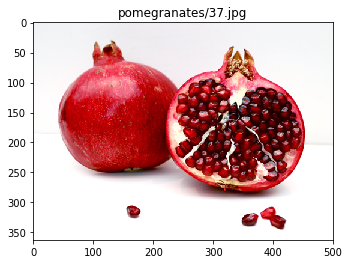

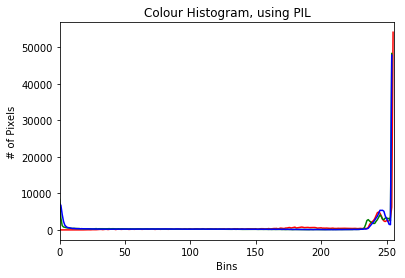

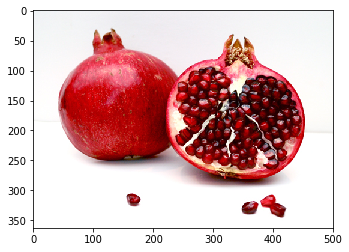

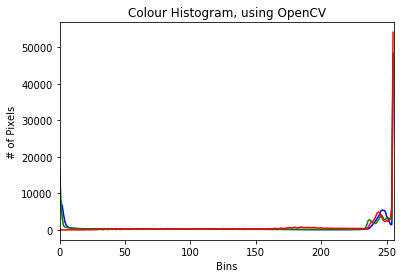

In [8]:
# Before we do actual feature extaction just for curiosity, let's look at one image, to illustrate what we are going to do

# import the necessary packages
from matplotlib import pyplot as plt

%matplotlib inline


# For OpenCV (need Version 2.4+) for Python 2.7, on Ubuntu Linux, just "sudo apt install python-opencv"
# In other OS, that might be different.

from PIL import Image

demoImageName = fileNames[1]
demoImage = imagePath + demoImageName
print("Showing demo feature extraction on image " + demoImage)

# load the image & plot it
imagePIL = Image.open(demoImage)
imgplot = plt.imshow(imagePIL)
plt.title(demoImageName)

# now we compute a colour histogram using the histogram function in pillow
# This gives us one histogram with 768 values, which is 3 x 256 values for each colour
# For each colour channel, each value repesent the count how many pixels have that colour intensity
featureVector=imagePIL.histogram()

# We plot this histogram
plt.figure()
plt.plot(featureVector[:256], 'r')
plt.plot(featureVector[257:512], 'g')
plt.plot(featureVector[513:], 'b')
plt.xlim([0, 256])
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.title("Colour Histogram, using PIL")

# An alternative is to use open CV
imageOpenCV = cv2.imread(demoImage)

# OpenCV is a bit weird, because it changes the channel order, it stores them as BGR, instead of RGB
# So if we want to display the image, we have to invert it
plt.figure()
plt.imshow(cv2.cvtColor(imageOpenCV, cv2.COLOR_BGR2RGB))

chans = cv2.split(imageOpenCV) # split the image in the different channels (RGB, but in open CV, it is BGR, actually..)
colors = ("b", "g", "r")
plt.figure()
plt.title("Colour Histogram, using OpenCV")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
featuresOpenCV = []

# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and add it to the resulting histograms array (of arrays)
    # We can specifiy here in the 4th argument how many bins we want - 256 means the same as in the previous histogram
    histOpenCV = cv2.calcHist([chan], [0], None, [256], [0, 256])
    featuresOpenCV.extend(histOpenCV)

    # plot the histogram of the current colour
    plt.plot(histOpenCV, color = color)
    plt.xlim([0, 256])
    
# Now we have a 2D-array - 256 values for each of 3 colour channels.
# To input this into our machine learning, we need to "flatten" the features into one larger 1D array
# the size of this will be 3 x 256 = 768 values
featureVectorOpenCV = np.array(featuresOpenCV).flatten()


# show all the plots
plt.show()

In [9]:
# Image Feature extractor
def extract_features(image_path, vector_size=32):
    image = imread(image_path, mode="RGB")
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Finding image keypoints
        kps = alg.detect(image)
        # Getting first 64 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc

In [10]:
# Simp eFeature extractor with KAZE
def efeature(image_path, vector_size=32, mode="L"):
    image = imread(image_path,mode=mode)# mode="RGB")
    try:
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        # first 32 sorted by size
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
    except cv2.error as e:
        print('Error: ', e)
        return None
        
    return kps, dsc

In [11]:
## plot metrics
def plot_measures(history, ds):
    hist = history.history
    hist.keys()
    
    colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve: " + ds) 
    plt.xlabel("Epoch")

    for measure in hist.keys():
        color = colors[measure]
        plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

In [12]:
# so NOW we actually extract features from our images
import datetime

print ("Extracting features using PIL/PILLOW" + " (" + str(datetime.datetime.now()) + ")")

# The simplest approach is via the PIL/PILLOW package; here we get a histogram over each RGB channel
# Note: this doesn't really represent colours, as a colour is made up of the combination of the three channels!
data=[]
#data_features = []
for index, fileName in enumerate(fileNames):
    
    imagePIL = Image.open(imagePath + fileName)
    # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
    # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
    imagePIL = imagePIL.convert('RGB')     
    featureVector=imagePIL.histogram()
    # TODO
    #image_features = extract_features(imagePath + fileName)
    
    if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
        print("Unexpected length of feature vector: " + str(len(featureVector)) + " in file: " + fileName)

    data.append((featureVector))
    #data_features.append((image_features))

    
# Next, we extract a few more features using OpenCV

print ("Extracting features using OpenCV" + " (" + str(datetime.datetime.now()) + ")")
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]
data_feature_vectors = []

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for fileName in fileNames:

    # the easiest way would to do the following:
    # imageOpenCV = cv2.imread(imagePath + fileName)

    # However, we have the same issue as before, and it is more difficult in OpenCV to convert to an RGB image
    # Thus we do this using PIL, and then convert to OpenCV ....
    imagePIL = Image.open(imagePath + fileName)
    imagePIL = imagePIL.convert('RGB')
    imageOpenCV = np.array(imagePIL) 
    # Convert RGB to BGR 
    imageOpenCV = imageOpenCV[:, :, ::-1].copy() 

    # Now we split the image in the three channels, B / G / R
    chans = cv2.split(imageOpenCV)
    colors = ("b", "g", "r")

    # First we do also features per channel, but this time, we aggregate them into a smaller number of bins
    # I.e. we do not have 256 values per channel, but less
    featuresOpenCV_1D = []
    bins_1D=64
    for (chan, color) in zip(chans, colors): # we compute the histogram over each channel
        histOpenCV = cv2.calcHist([chan], [0], None, [bins_1D], [0, 256])
        featuresOpenCV_1D.extend(histOpenCV)
    featureVectorOpenCV_1D = flatten(featuresOpenCV_1D) # and append this to our feature vector
    
    dataOpenCV_1D.append(featureVectorOpenCV_1D) # now we append the feature vector to the dataset so far

    if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
        print ("Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + fileName)

    # Next - features that look at two channels at the same time
    # E.g. we look at when green and blue have both "high values"
    # We reduce the size of bins further, to not have a too long feature vector
    featuresOpenCV_2D = []
    bins2D=16
    # look at all combinations of channels (R & B, R & G, B & G)
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[0]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[0], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    # and add that to our dataset
    featureVectorOpenCV_2D = flatten(featuresOpenCV_2D)
    dataOpenCV_2D.append(featureVectorOpenCV_2D)

    # finally, we look at all three channels at the same time.
    # We further reduce our bin size, because otherwise, this would become very large...
    featuresOpenCV_3D = cv2.calcHist([imageOpenCV], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # append to our dataset
    featureVectorOpenCV_3D = featuresOpenCV_3D.flatten()
    dataOpenCV_3D.append(featureVectorOpenCV_3D)
    
    # image feature vector extraction with KAZE (caching is implemented below)
    #for index, fileName in enumerate(fileNames):
    print(".... START (image feature extraction with KAZE)" + " (" + str(datetime.datetime.now()) + ")")
    print("Opening KAZE", str(imagePath + fileName) , " ...")
    image_feature_vec = extract_features(imagePath + fileName)
    data_feature_vectors.append((image_feature_vec))

print(".... KAZE END" + " (" + str(datetime.datetime.now()) + ")")        
print(".... done" + " (" + str(datetime.datetime.now()) + ")")

Extracting features using PIL/PILLOW (2019-02-18 13:32:39.523733)
Extracting features using OpenCV (2019-02-18 13:33:36.706859)
.... START (image feature extraction with KAZE) (2019-02-18 13:33:36.756754)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/22.jpg  ...


/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


.... START (image feature extraction with KAZE) (2019-02-18 13:33:38.135668)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/37.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:33:38.471430)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/41.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:33:38.685690)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/20.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:33:38.878449)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/7.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:33:39.099574)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/29.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:33:39.527602)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pomegranates/1.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:33:44.722

.... START (image feature extraction with KAZE) (2019-02-18 13:36:05.787697)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/peaches/50.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:36:06.092122)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/peaches/30.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:36:09.313743)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/raspberries/37.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:36:09.847797)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/raspberries/41.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:36:12.680588)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/raspberries/20.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:36:13.793777)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/raspberries/7.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:36:39.511544)
Opening 

.... START (image feature extraction with KAZE) (2019-02-18 13:39:43.517512)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/guava/43.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:39:43.768801)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/guava/12.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:39:44.225798)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/guava/34.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:39:44.859891)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/guava/10.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:39:45.094735)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/guava/9.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:39:45.467847)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/guava/14.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:39:46.038568)
Opening KAZE /home/xxx/MScBI/S4/ML/e

.... START (image feature extraction with KAZE) (2019-02-18 13:42:44.876632)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apricots/47.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:42:45.600982)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apricots/13.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:42:47.183734)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apricots/4.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:42:47.901330)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apricots/43.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:43:00.569388)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apricots/36.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:43:00.951442)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apricots/10.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:43:01.342669)
Opening KAZE /home

.... START (image feature extraction with KAZE) (2019-02-18 13:44:59.751917)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/cherries/22.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:45:00.237862)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/cherries/37.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:45:04.936161)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/cherries/41.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:45:10.183889)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/cherries/20.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:45:10.537659)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/cherries/11.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:45:13.843507)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/cherries/28.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:45:29.333586)
Opening KAZE /hom

.... START (image feature extraction with KAZE) (2019-02-18 13:47:46.485877)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/oranges/31.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:48:11.018274)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/oranges/26.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:48:11.499615)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/oranges/5.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:48:17.449112)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/oranges/48.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:48:17.609821)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/oranges/3.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:48:18.089694)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/oranges/25.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:48:22.533132)
Opening KAZE /home/xxx/MS

.... START (image feature extraction with KAZE) (2019-02-18 13:51:17.744856)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/acerolas/10.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:51:19.800553)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/acerolas/19.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:51:20.128110)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/acerolas/18.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:51:20.371685)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/acerolas/21.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:51:20.600559)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/acerolas/23.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:51:20.880848)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/acerolas/5.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:51:21.413334)
Opening KAZE /home

.... START (image feature extraction with KAZE) (2019-02-18 13:54:04.865937)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/strawberries/17.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:54:13.643683)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/strawberries/52.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:54:14.412408)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/strawberries/42.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:54:25.231592)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/strawberries/38.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:54:26.526543)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/strawberries/55.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:54:26.785526)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/strawberries/6.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:54:28.85

.... START (image feature extraction with KAZE) (2019-02-18 13:56:46.389352)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pineapples/53.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:56:47.933517)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pineapples/35.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:56:55.226875)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pineapples/25.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:56:56.823334)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pineapples/2.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:56:57.423462)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pineapples/50.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:57:04.821729)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pineapples/17.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:57:05.009991)
Openin

.... START (image feature extraction with KAZE) (2019-02-18 13:59:51.810425)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/limes/35.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 13:59:53.373508)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/limes/3.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:00:00.011265)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/limes/25.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:00:03.919616)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/limes/2.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:00:04.193335)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/limes/52.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:00:04.507638)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/limes/57.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:00:05.107782)
Opening KAZE /home/xxx/MScBI/S4/ML/ex

.... START (image feature extraction with KAZE) (2019-02-18 14:03:17.597364)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apples/19.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:03:17.781092)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apples/9.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:03:19.087732)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apples/54.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:03:31.083040)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apples/14.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:03:35.178648)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apples/0.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:03:44.251047)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/apples/40.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:03:49.480579)
Opening KAZE /home/xxx/MScBI/S4

.... START (image feature extraction with KAZE) (2019-02-18 14:06:13.609753)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/kiwifruit/7.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:06:13.886644)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/kiwifruit/11.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:06:14.396766)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/kiwifruit/45.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:06:14.906503)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/kiwifruit/1.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:06:15.852410)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/kiwifruit/47.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:06:24.255599)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/kiwifruit/49.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:06:27.156589)
Opening KAZE 

.... START (image feature extraction with KAZE) (2019-02-18 14:09:37.018683)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapefruits/26.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:09:37.356640)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapefruits/8.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:09:37.642041)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapefruits/5.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:09:38.011879)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapefruits/16.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:09:39.609584)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapefruits/46.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:09:40.540894)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapefruits/48.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:09:40.994154)
O

.... START (image feature extraction with KAZE) (2019-02-18 14:13:23.564221)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/mangos/8.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:13:25.371889)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/mangos/16.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:13:34.774549)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/mangos/46.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:13:35.055782)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/mangos/56.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:13:35.748703)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/mangos/48.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:13:44.022913)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/mangos/53.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:13:44.482253)
Opening KAZE /home/xxx/MScBI/S

.... START (image feature extraction with KAZE) (2019-02-18 14:16:40.168266)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/blackberries/19.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:16:42.408747)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/blackberries/9.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:16:45.018858)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/blackberries/54.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:17:11.336714)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/blackberries/27.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:17:13.375566)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/blackberries/14.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:17:14.360423)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/blackberries/0.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:17:32.037

.... START (image feature extraction with KAZE) (2019-02-18 14:19:32.812145)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapes/57.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:19:42.159780)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapes/55.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:19:52.517451)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapes/6.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:19:56.644868)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/grapes/15.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:19:57.424852)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pears/37.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:20:04.278020)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/pears/20.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:20:05.019686)
Opening KAZE /home/xxx/MScBI/S4/

.... START (image feature extraction with KAZE) (2019-02-18 14:23:17.754264)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/bananas/51.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:23:21.654107)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/bananas/40.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:23:24.671088)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/bananas/21.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:23:25.393458)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/bananas/23.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:23:35.123385)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/bananas/31.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:23:36.324063)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/bananas/26.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:23:36.788343)
Opening KAZE /home/xxx/

.... START (image feature extraction with KAZE) (2019-02-18 14:29:18.361460)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/tomatoes/45.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:29:35.043806)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/tomatoes/28.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:30:01.645696)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/tomatoes/1.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:30:02.185073)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/tomatoes/47.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:30:12.737469)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/tomatoes/49.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:30:13.277442)
Opening KAZE /home/xxx/MScBI/S4/ML/exer3/data/FIDS30/tomatoes/13.jpg  ...
.... START (image feature extraction with KAZE) (2019-02-18 14:30:15.914617)
Opening KAZE /home

In [13]:
## Simple Feature extractor with KAZE ##

# Bag of visual words
preprocessed_image_BOV = []

# K-means clustering with 100 "word" bags
kmeans = KMeans(n_clusters = 200)

def efeature(image_path, vector_size=32, mode="RGB"):
    image = imread(image_path,mode=mode)# mode="RGB")
    try:
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        # first 32 sorted by size
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
    except cv2.error as e:
        print('Error: ', e)
        return None
        
    return kps, dsc


def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram



# generate list of image vector features 
print(".... START (image feature extraction)" + " (" + str(datetime.datetime.now()) + ")")
dsc_list = None
for image in fileNames:
    print("opening ....", image)
    #image = gray(image)
    keypoint, descriptor = efeature(imagePath + image, mode="RGB")
    if (descriptor is not None):
        if (dsc_list is None):
            print(descriptor.shape)
            dsc_list = descriptor
        else:
            print(dsc_list.shape)
            dsc_list = np.append(dsc_list, descriptor, axis=0)
print(".... END (image feature extraction)" + " (" + str(datetime.datetime.now()) + ")")
  
#cluster image feature vectors
kmeans.fit(dsc_list)

.... START (image feature extraction) (2019-02-18 14:32:08.320794)
opening .... pomegranates/22.jpg


/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(32, 64)
opening .... pomegranates/37.jpg
(32, 64)
opening .... pomegranates/41.jpg
(64, 64)
opening .... pomegranates/20.jpg
(96, 64)
opening .... pomegranates/7.jpg
(128, 64)
opening .... pomegranates/29.jpg
(160, 64)
opening .... pomegranates/1.jpg
(192, 64)
opening .... pomegranates/33.jpg
(224, 64)
opening .... pomegranates/4.jpg
(256, 64)
opening .... pomegranates/36.jpg
(288, 64)
opening .... pomegranates/12.jpg
(320, 64)
opening .... pomegranates/34.jpg
(352, 64)
opening .... pomegranates/10.jpg
(384, 64)
opening .... pomegranates/19.jpg
(416, 64)
opening .... pomegranates/54.jpg
(448, 64)
opening .... pomegranates/0.jpg
(480, 64)
opening .... pomegranates/18.jpg
(512, 64)
opening .... pomegranates/21.jpg
(544, 64)
opening .... pomegranates/23.jpg
(576, 64)
opening .... pomegranates/26.jpg
(608, 64)
opening .... pomegranates/8.jpg
(640, 64)
opening .... pomegranates/5.jpg
(672, 64)
opening .... pomegranates/3.jpg
(704, 64)
opening .... pomegranates/2.jpg
(736, 64)
opening .... 

(6560, 64)
opening .... watermelons/8.jpg
(6592, 64)
opening .... watermelons/5.jpg
(6624, 64)
opening .... watermelons/16.jpg
(6656, 64)
opening .... watermelons/46.jpg
(6688, 64)
opening .... watermelons/48.jpg
(6720, 64)
opening .... watermelons/53.jpg
(6752, 64)
opening .... watermelons/3.jpg
(6784, 64)
opening .... watermelons/2.jpg
(6816, 64)
opening .... watermelons/50.jpg
(6848, 64)
opening .... watermelons/52.jpg
(6880, 64)
opening .... watermelons/42.jpg
(6912, 64)
opening .... watermelons/30.jpg
(6944, 64)
opening .... watermelons/38.jpg
(6976, 64)
opening .... cherries/22.jpg
(7008, 64)
opening .... cherries/37.jpg
(7040, 64)
opening .... cherries/41.jpg
(7072, 64)
opening .... cherries/20.jpg
(7104, 64)
opening .... cherries/11.jpg
(7136, 64)
opening .... cherries/28.jpg
(7168, 64)
opening .... cherries/1.jpg
(7200, 64)
opening .... cherries/47.jpg
(7232, 64)
opening .... cherries/49.jpg
(7264, 64)
opening .... cherries/13.jpg
(7296, 64)
opening .... cherries/44.jpg
(7328,

(12826, 64)
opening .... passionfruit/9.jpg
(12858, 64)
opening .... passionfruit/27.jpg
(12890, 64)
opening .... passionfruit/0.jpg
(12922, 64)
opening .... passionfruit/23.jpg
(12954, 64)
opening .... passionfruit/8.jpg
(12986, 64)
opening .... passionfruit/5.jpg
(13018, 64)
opening .... passionfruit/2.jpg
(13050, 64)
opening .... passionfruit/17.jpg
(13082, 64)
opening .... passionfruit/30.jpg
(13114, 64)
opening .... pineapples/22.jpg
(13146, 64)
opening .... pineapples/41.jpg
(13178, 64)
opening .... pineapples/20.jpg
(13210, 64)
opening .... pineapples/7.jpg
(13242, 64)
opening .... pineapples/32.jpg
(13274, 64)
opening .... pineapples/11.jpg
(13306, 64)
opening .... pineapples/1.jpg
(13338, 64)
opening .... pineapples/24.jpg
(13370, 64)
opening .... pineapples/33.jpg
(13402, 64)
opening .... pineapples/13.jpg
(13434, 64)
opening .... pineapples/44.jpg
(13466, 64)
opening .... pineapples/4.jpg
(13498, 64)
opening .... pineapples/36.jpg
(13530, 64)
opening .... pineapples/12.jpg
(

(19310, 64)
opening .... kiwifruit/1.jpg
(19342, 64)
opening .... kiwifruit/47.jpg
(19374, 64)
opening .... kiwifruit/49.jpg
(19406, 64)
opening .... kiwifruit/13.jpg
(19438, 64)
opening .... kiwifruit/4.jpg
(19470, 64)
opening .... kiwifruit/36.jpg
(19502, 64)
opening .... kiwifruit/10.jpg
(19534, 64)
opening .... kiwifruit/19.jpg
(19566, 64)
opening .... kiwifruit/9.jpg
(19598, 64)
opening .... kiwifruit/27.jpg
(19630, 64)
opening .... kiwifruit/14.jpg
(19662, 64)
opening .... kiwifruit/0.jpg
(19694, 64)
opening .... kiwifruit/40.jpg
(19726, 64)
opening .... kiwifruit/18.jpg
(19758, 64)
opening .... kiwifruit/21.jpg
(19790, 64)
opening .... kiwifruit/8.jpg
(19822, 64)
opening .... kiwifruit/58.jpg
(19854, 64)
opening .... kiwifruit/5.jpg
(19886, 64)
opening .... kiwifruit/16.jpg
(19918, 64)
opening .... kiwifruit/46.jpg
(19950, 64)
opening .... kiwifruit/56.jpg
(19982, 64)
opening .... kiwifruit/48.jpg
(20014, 64)
opening .... kiwifruit/3.jpg
(20046, 64)
opening .... kiwifruit/25.jpg

(25638, 64)
opening .... grapes/9.jpg
(25670, 64)
opening .... grapes/27.jpg
(25702, 64)
opening .... grapes/14.jpg
(25734, 64)
opening .... grapes/0.jpg
(25766, 64)
opening .... grapes/51.jpg
(25798, 64)
opening .... grapes/21.jpg
(25830, 64)
opening .... grapes/31.jpg
(25862, 64)
opening .... grapes/26.jpg
(25894, 64)
opening .... grapes/8.jpg
(25926, 64)
opening .... grapes/5.jpg
(25958, 64)
opening .... grapes/16.jpg
(25990, 64)
opening .... grapes/46.jpg
(26022, 64)
opening .... grapes/39.jpg
(26054, 64)
opening .... grapes/35.jpg
(26086, 64)
opening .... grapes/17.jpg
(26118, 64)
opening .... grapes/52.jpg
(26150, 64)
opening .... grapes/42.jpg
(26182, 64)
opening .... grapes/30.jpg
(26214, 64)
opening .... grapes/57.jpg
(26246, 64)
opening .... grapes/55.jpg
(26278, 64)
opening .... grapes/6.jpg
(26310, 64)
opening .... grapes/15.jpg
(26342, 64)
opening .... pears/37.jpg
(26374, 64)
opening .... pears/20.jpg
(26406, 64)
opening .... pears/7.jpg
(26438, 64)
opening .... pears/29.

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

KAZE Image feature extraction takes about 1 hour 15 minutes.

In [14]:
for image in fileNames:
    print("opening ....", image)
    keypoint, descriptor = efeature(imagePath + image, mode="RGB")
    if (descriptor is not None):
        histogram = build_histogram(descriptor, kmeans)
        preprocessed_image_BOV.append(histogram)

opening .... pomegranates/22.jpg


/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


opening .... pomegranates/37.jpg
opening .... pomegranates/41.jpg
opening .... pomegranates/20.jpg
opening .... pomegranates/7.jpg
opening .... pomegranates/29.jpg
opening .... pomegranates/1.jpg
opening .... pomegranates/33.jpg
opening .... pomegranates/4.jpg
opening .... pomegranates/36.jpg
opening .... pomegranates/12.jpg
opening .... pomegranates/34.jpg
opening .... pomegranates/10.jpg
opening .... pomegranates/19.jpg
opening .... pomegranates/54.jpg
opening .... pomegranates/0.jpg
opening .... pomegranates/18.jpg
opening .... pomegranates/21.jpg
opening .... pomegranates/23.jpg
opening .... pomegranates/26.jpg
opening .... pomegranates/8.jpg
opening .... pomegranates/5.jpg
opening .... pomegranates/3.jpg
opening .... pomegranates/2.jpg
opening .... pomegranates/17.jpg
opening .... pomegranates/52.jpg
opening .... pomegranates/42.jpg
opening .... pomegranates/30.jpg
opening .... pomegranates/55.jpg
opening .... pomegranates/6.jpg
opening .... peaches/22.jpg
opening .... peaches/41.

opening .... oranges/52.jpg
opening .... oranges/42.jpg
opening .... oranges/30.jpg
opening .... oranges/55.jpg
opening .... oranges/15.jpg
opening .... blueberries/37.jpg
opening .... blueberries/20.jpg
opening .... blueberries/7.jpg
opening .... blueberries/29.jpg
opening .... blueberries/11.jpg
opening .... blueberries/1.jpg
opening .... blueberries/47.jpg
opening .... blueberries/13.jpg
opening .... blueberries/44.jpg
opening .... blueberries/4.jpg
opening .... blueberries/12.jpg
opening .... blueberries/34.jpg
opening .... blueberries/10.jpg
opening .... blueberries/27.jpg
opening .... blueberries/14.jpg
opening .... blueberries/0.jpg
opening .... blueberries/40.jpg
opening .... blueberries/31.jpg
opening .... blueberries/26.jpg
opening .... blueberries/58.jpg
opening .... blueberries/5.jpg
opening .... blueberries/16.jpg
opening .... blueberries/59.jpg
opening .... blueberries/56.jpg
opening .... blueberries/48.jpg
opening .... blueberries/53.jpg
opening .... blueberries/3.jpg
op

opening .... apples/2.jpg
opening .... apples/50.jpg
opening .... apples/17.jpg
opening .... apples/52.jpg
opening .... apples/42.jpg
opening .... apples/38.jpg
opening .... apples/55.jpg
opening .... apples/15.jpg
opening .... cantaloupes/22.jpg
opening .... cantaloupes/7.jpg
opening .... cantaloupes/45.jpg
opening .... cantaloupes/1.jpg
opening .... cantaloupes/24.jpg
opening .... cantaloupes/33.jpg
opening .... cantaloupes/49.jpg
opening .... cantaloupes/13.jpg
opening .... cantaloupes/44.jpg
opening .... cantaloupes/4.jpg
opening .... cantaloupes/43.jpg
opening .... cantaloupes/12.jpg
opening .... cantaloupes/34.jpg
opening .... cantaloupes/19.jpg
opening .... cantaloupes/14.jpg
opening .... cantaloupes/0.jpg
opening .... cantaloupes/40.jpg
opening .... cantaloupes/18.jpg
opening .... cantaloupes/21.jpg
opening .... cantaloupes/31.jpg
opening .... cantaloupes/5.jpg
opening .... cantaloupes/16.jpg
opening .... cantaloupes/3.jpg
opening .... cantaloupes/25.jpg
opening .... cantaloupe

opening .... pears/0.jpg
opening .... pears/40.jpg
opening .... pears/18.jpg
opening .... pears/21.jpg
opening .... pears/23.jpg
opening .... pears/31.jpg
opening .... pears/26.jpg
opening .... pears/8.jpg
opening .... pears/5.jpg
opening .... pears/16.jpg
opening .... pears/2.jpg
opening .... pears/52.jpg
opening .... pears/42.jpg
opening .... pears/30.jpg
opening .... pears/15.jpg
opening .... bananas/22.jpg
opening .... bananas/37.jpg
opening .... bananas/29.jpg
opening .... bananas/32.jpg
opening .... bananas/11.jpg
opening .... bananas/28.jpg
opening .... bananas/1.jpg
opening .... bananas/47.jpg
opening .... bananas/49.jpg
opening .... bananas/13.jpg
opening .... bananas/4.jpg
opening .... bananas/43.jpg
opening .... bananas/36.jpg
opening .... bananas/12.jpg
opening .... bananas/34.jpg
opening .... bananas/10.jpg
opening .... bananas/9.jpg
opening .... bananas/54.jpg
opening .... bananas/27.jpg
opening .... bananas/14.jpg
opening .... bananas/51.jpg
opening .... bananas/40.jpg
o

(array([175.,   0.,   0.,  19.,   0.,   0.,   5.,   0.,   0.,   1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

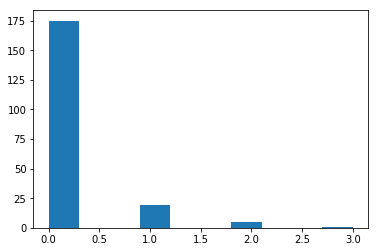

In [15]:
## check BOVW
plt.hist(preprocessed_image_BOV[83])

### Persist vector features

In [16]:
# persist image vector features
#preprocessed_image_BOV[0:2]
np.save("/home/xxx/DS/ML/preprocessed_image_BOVW", preprocessed_image_BOV)
np.save("/home/xxx/DS/ML/data_feature_vectors", data_feature_vectors)


### Run this line instead of rather lenghty feature extraction

In [5]:
#preprocessed_image_BOV = np.load("preprocessed_image_BOVW.npy")
#data_feature_vectors = np.load("data_feature_vectors.npy")

### Configure Neural Network

First layer has the same number of neurons as input data dimensions.
Hidden layers  length is 80% of the input size + the number of output variables. 

In [17]:
from keras.optimizers import SGD

def get_model(input_shape, hidden_layer_number, hidden_layer_activation, target_layer_activation):
    # simple Fully-connected network
    
    first_layer_size = input_shape
    print("first layer size: ", str(first_layer_size))
    hidden_layer_size = int((0.8 * input_shape)+len(set(targetLabels)))
    print("hidden layer size:", hidden_layer_size)
    
    model = Sequential()
    model.add(Dense(first_layer_size, input_dim=input_shape, activation = hidden_layer_activation))
    for i in range(1,hidden_layer_number):
        print("adding layer...", i)
        model.add(Dense((hidden_layer_size), activation = hidden_layer_activation))
        #model.add(Dense((1000), activation='relu'))
    model.add(Dense(len(set(targetLabels)), activation = target_layer_activation))
    model.summary()
    # Define a loss function 
    loss = 'categorical_crossentropy'
    # Optimizer = Stochastic Gradient Descent
    optimizer = keras.optimizers.Nadam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)#"NAdam"#(lr=0.01)
    #optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)#SGD(lr=0.01)
    #optimizer = "adam"
    # Compiling the model
    # This creates the whole model structure in memory. 
    # If you use GPU computation, here GPU compatible structures and code is generated.
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [18]:
target.shape

(971,)

(array([ 16.,  94., 831., 656., 234., 129.,  60.,  19.,   4.,   5.]),
 array([-0.2266169 , -0.13961223, -0.05260756,  0.03439711,  0.12140179,
         0.20840645,  0.29541114,  0.3824158 ,  0.46942046,  0.55642515,
         0.6434298 ], dtype=float32),
 <a list of 10 Patch objects>)

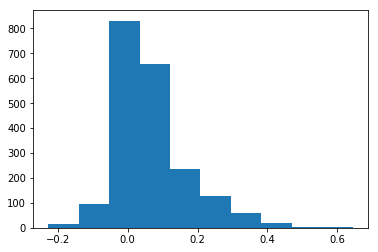

In [19]:
plt.hist(data_feature_vectors[50])

In [20]:
np.count_nonzero([0,1,5])
data_feature_vectors[758].shape

(2048,)

## Run algorithms on different datasets
###  Deep Learning - Multilayer Perceptron

### experimental setup

Classifier: MLP, dataset(features):  BOVW
first layer size:  200
hidden layer size: 190
adding layer... 1
adding layer... 2
adding layer... 3
adding layer... 4
adding layer... 5
adding layer... 6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_106 (Dense)            (None, 190)               38190     
_________________________________________________________________
dense_107 (Dense)            (None, 190)               36290     
_________________________________________________________________
dense_108 (Dense)            (None, 190)               36290     
_________________________________________________________________
dense_109 (Dense)            (None, 190)               36290     
_________________________________________________________________
dense_110 (D

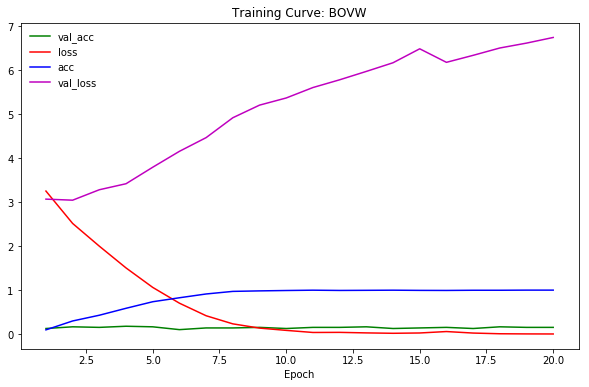

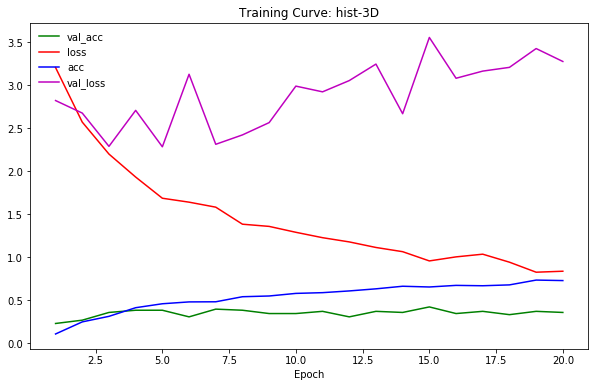

In [26]:
trainingSets = [preprocessed_image_BOV, dataOpenCV_3D]
trainingSetNames = ["BOVW","hist-3D"]

# Do Deep Learning on different datasets
# Now iterate over the datasets & classifiers, and train...
for train, ds_name in zip(trainingSets, trainingSetNames):
    print("Classifier: MLP, dataset(features): ",ds_name)
    # convert to float
    train = np.array(train, dtype=config.floatX)

    # normalize
    mean = train.mean()
    stddev = train.std()
    train  = (train - mean) / stddev

    # split to train, validate, test
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=1)

    # encode y_test for NN
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    # convert integers to dummy variables (i.e. one hot encoded)
    y_NN_train = np_utils.to_categorical(encoded_Y)
    #dummy_y


    epochs = 20
    input_shape = X_train.shape[1]
    
    # model with 1 hidden layers 
    nr_hidden_layers = 7
    hidden_layer_activation = "elu"
    target_layer_activation = "softmax"
    model = get_model(input_shape, nr_hidden_layers, hidden_layer_activation, target_layer_activation)
    print("input shape:", input_shape)
    print("hidden_layer_activation:", hidden_layer_activation)
    print("target_layer_activation:", target_layer_activation)
    print(" .. NN MODEL TRAIN START (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    history = model.fit(X_train, y_NN_train, batch_size=4, epochs=epochs, validation_split=0.1) #, validation_data=validation_data)
    print(" .. NN MODEL TRAIN END (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    # verify Accuracy on Train set# verify 
    print(" .. NN MODEL PREDICT START (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    predictions = model.predict_classes(X_test)
    print(" .. NN MODEL PREDICT END (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    #print("Precision: ", round(precision_score(y_NN_test, predictions, average='micro'),2))
    print(classification_report(y_test, predictions, target_names=list(le.classes_)))
    plot_measures(history, ds_name)


#### MLP on all datasets

Classifier: MLP, dataset(features):  keypoints
first layer size:  2048
hidden layer size: 1668
adding layer... 1
adding layer... 2
adding layer... 3
adding layer... 4
adding layer... 5
adding layer... 6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_10 (Dense)             (None, 1668)              3417732   
_________________________________________________________________
dense_11 (Dense)             (None, 1668)              2783892   
_________________________________________________________________
dense_12 (Dense)             (None, 1668)              2783892   
_________________________________________________________________
dense_13 (Dense)             (None, 1668)              2783892   
_________________________________________________________________
dense

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


adding layer... 6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 192)               37056     
_________________________________________________________________
dense_18 (Dense)             (None, 183)               35319     
_________________________________________________________________
dense_19 (Dense)             (None, 183)               33672     
_________________________________________________________________
dense_20 (Dense)             (None, 183)               33672     
_________________________________________________________________
dense_21 (Dense)             (None, 183)               33672     
_________________________________________________________________
dense_22 (Dense)             (None, 183)               33672     
_________________________________________________________________
dense_23 (Dense)             (None, 183)               336

698/698 [==============================] - 10s 15ms/step - loss: 2.6933 - acc: 0.2178 - val_loss: 2.7643 - val_acc: 0.2436
Epoch 3/20
698/698 [==============================] - 10s 14ms/step - loss: 2.4699 - acc: 0.2708 - val_loss: 2.5107 - val_acc: 0.3205
Epoch 4/20
698/698 [==============================] - 10s 15ms/step - loss: 2.1605 - acc: 0.3467 - val_loss: 3.1372 - val_acc: 0.2051
Epoch 5/20
698/698 [==============================] - 10s 14ms/step - loss: 2.0041 - acc: 0.3997 - val_loss: 2.7980 - val_acc: 0.3077
Epoch 6/20
698/698 [==============================] - 10s 14ms/step - loss: 1.8806 - acc: 0.3968 - val_loss: 2.6585 - val_acc: 0.3333
Epoch 7/20
698/698 [==============================] - 10s 14ms/step - loss: 1.7652 - acc: 0.4656 - val_loss: 2.8516 - val_acc: 0.2949
Epoch 8/20
698/698 [==============================] - 11s 15ms/step - loss: 1.7210 - acc: 0.4585 - val_loss: 3.0283 - val_acc: 0.3077
Epoch 9/20
698/698 [==============================] - 10s 14ms/step - los

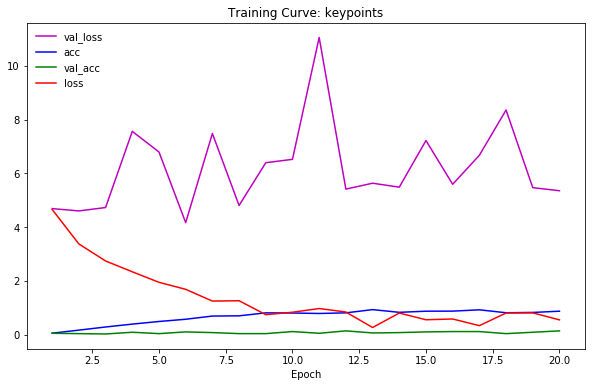

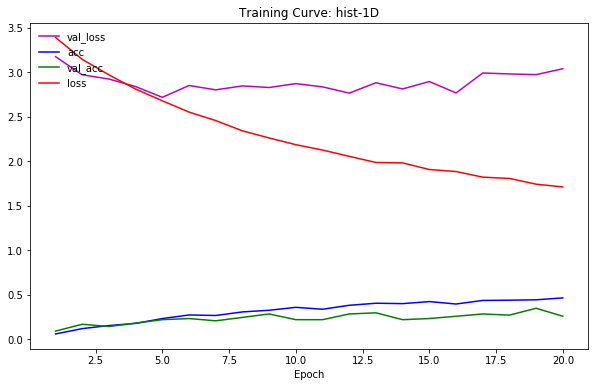

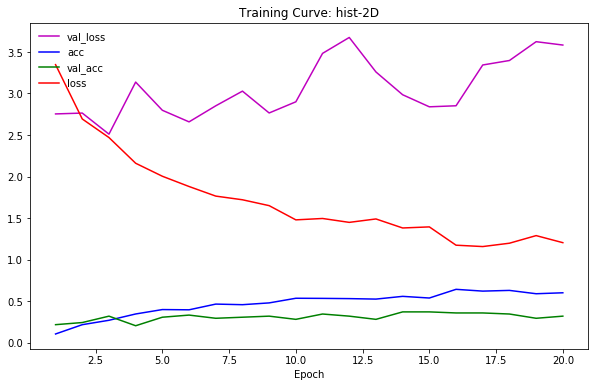

In [22]:

# these are our feature sets; we will use each of them individually to train classifiers
trainingSets = [data_feature_vectors, dataOpenCV_1D, dataOpenCV_2D]
trainingSetNames = ["keypoints","hist-1D","hist-2D"]

#trainingSets = [preprocessed_image_BOV, dataOpenCV_3D]
#trainingSetNames = ["BOVW","hist-3D"]

# Do Deep Learning on different datasets
# Now iterate over the datasets & classifiers, and train...
for train, ds_name in zip(trainingSets, trainingSetNames):
    print("Classifier: MLP, dataset(features): ",ds_name)
    # convert to float
    train = np.array(train, dtype=config.floatX)

    # normalize
    mean = train.mean()
    stddev = train.std()
    train  = (train - mean) / stddev

    # split to train, validate, test
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=1)

    # encode y_test for NN
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    # convert integers to dummy variables (i.e. one hot encoded)
    y_NN_train = np_utils.to_categorical(encoded_Y)
    #dummy_y


    epochs = 20
    input_shape = X_train.shape[1]
    
    # model with 1 hidden layers 
    nr_hidden_layers = 7
    hidden_layer_activation = "elu"
    target_layer_activation = "softmax"
    model = get_model(input_shape, nr_hidden_layers, hidden_layer_activation, target_layer_activation)
    print("input shape:", input_shape)
    print("hidden_layer_activation:", hidden_layer_activation)
    print("target_layer_activation:", target_layer_activation)
    print(" .. NN MODEL TRAIN START (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    history = model.fit(X_train, y_NN_train, batch_size=4, epochs=epochs, validation_split=0.1) #, validation_data=validation_data)
    print(" .. NN MODEL TRAIN END (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    # verify Accuracy on Train set# verify 
    print(" .. NN MODEL PREDICT START (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    predictions = model.predict_classes(X_test)
    print(" .. NN MODEL PREDICT END (hiddenL: "+str(nr_hidden_layers)+")" + " (" + str(datetime.datetime.now()) + ")") 
    #print("Precision: ", round(precision_score(y_NN_test, predictions, average='micro'),2))
    print(classification_report(y_test, predictions, target_names=list(le.classes_)))
    plot_measures(history, ds_name)
    

#### MLP with 10 hidden layer on multiple datasets

In [ ]:
for train, ds_name in zip(trainingSets, trainingSetNames):
    print("Classifier: MLP, dataset(features): ",ds_name)
    # convert to float
    train = np.array(train, dtype=config.floatX)

    # normalize
    mean = train.mean()
    stddev = train.std()
    train  = (train - mean) / stddev

    # split to train, validate, test
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=1)

    # encode y_test for NN
    encoder = LabelEncoder()
    encoder.fit(y_train)
    encoded_Y = encoder.transform(y_train)
    # convert integers to dummy variables (i.e. one hot encoded)
    y_NN_train = np_utils.to_categorical(encoded_Y)
    #dummy_y


    epochs = 10
    input_shape = X_train.shape[1]
    
    # model with 1 hidden layers 
    model = get_model(input_shape, 11)
    history = model.fit(X_train, y_NN_train, batch_size=4, epochs=epochs, validation_split=0.1) #, validation_data=validation_data)
    # verify Accuracy on Train set# verify 
    predictions = model.predict_classes(X_test)
    #print("Precision: ", round(precision_score(y_NN_test, predictions, average='micro'),2))
    print(classification_report(y_test, predictions, target_names=list(le.classes_)))
    plot_measures(history, ds_name)

### Test classic ML classifiers

In [76]:
# set up a number of classifiers
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.GaussianNB(), 
               tree.DecisionTreeClassifier(),
               ensemble.RandomForestClassifier(),
               svm.SVC(),
               svm.LinearSVC(),
              ]

classifier_names = ["KNN", "NaiveBayes", "DecisionTree", "RandomForest", "SVC", "LinearSVC"]

# Now iterate over the datasets & classifiers, and train...
for train, ds_name in zip(trainingSets, trainingSetNames):
    print("##### dataset(features): ",ds_name, " #####")
    # convert to float
    train = np.array(train, dtype=config.floatX)

    # normalize
    mean = train.mean()
    stddev = train.std()
    train  = (train - mean) / stddev

    # split to train, validate, test
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=1)
    
    for classifier, name in zip(classifiers, classifier_names):
        classifier.fit(X_train,y_train)
        pred = classifier.predict(X_test)
        print("Classifier: ", name, ", Precision: ", round(precision_score(y_test, pred, average='micro'),2))

##### dataset(features):  simple-hist  #####
Classifier:  KNN , Precision:  0.07
Classifier:  NaiveBayes , Precision:  0.11
Classifier:  DecisionTree , Precision:  0.12
Classifier:  RandomForest , Precision:  0.19
Classifier:  SVC , Precision:  0.04
Classifier:  LinearSVC , Precision:  0.23
##### dataset(features):  keypoints  #####
Classifier:  KNN , Precision:  0.07
Classifier:  NaiveBayes , Precision:  0.14
Classifier:  DecisionTree , Precision:  0.07
Classifier:  RandomForest , Precision:  0.05
Classifier:  SVC , Precision:  0.12
Classifier:  LinearSVC , Precision:  0.11
##### dataset(features):  BOW  #####
Classifier:  KNN , Precision:  0.16
Classifier:  NaiveBayes , Precision:  0.14
Classifier:  DecisionTree , Precision:  0.12
Classifier:  RandomForest , Precision:  0.13
Classifier:  SVC , Precision:  0.18
Classifier:  LinearSVC , Precision:  0.22
##### dataset(features):  hist-1D  #####
Classifier:  KNN , Precision:  0.08
Classifier:  NaiveBayes , Precision:  0.11
Classifier:  D

## Test CNN - TODO

In [71]:
def createCNNModel(input_shape):
    
    model = Sequential()

    n_filters = 16
    # this applies n_filters convolution filters of size 5x5 resp. 3x3 each in the 2 layers below

    # Layer 1
    model.add(Convolution2D(n_filters, 3, 3, border_mode='valid', input_shape=input_shape))
    # input shape: 100x100 images with 3 channels -> input_shape should be (3, 100, 100) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # ReLu activation
    model.add(MaxPooling2D(pool_size=(2, 2))) # reducing image resolution by half
    model.add(Dropout(0.3))  # random "deletion" of %-portion of units in each batch

    # Layer 2
    model.add(Convolution2D(n_filters, 3, 3))  # input_shape is only needed in 1st layer
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten()) # Note: Keras does automatic shape inference.
    
    # Full Layer
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.1))

    model.add(Dense(len(set(targetLabels)),activation='sigmoid'))
    
    return model

In [43]:
# TRAINING the model
#epochs = 15
#history = model.fit(train_img, classes, batch_size=32, nb_epoch=epochs)

In [72]:
#for fileN in fileNames:
#    print(imagePath + fileN)

images = []
image_names = []
img_arr = None

for filename in fileNames:
    image_names.append(os.path.basename(filename))
    with Image.open(filename).convert('RGB') as img:
        img_resized = resizeimage.resize_cover(img, [200, 200])#resize_and_crop(img,(100,40))
         # we convert the images to a Numpy array and store them in a list
        new_img = np.array(img_resized, dtype=config.floatX)
        images.append(new_img)
      
# convert
image_arr_new = np.array(images)

# normalize
mean = image_arr_new.mean()
stddev = image_arr_new.std()
image_arr_new  = (image_arr_new - mean) / stddev

train_img_cnn = image_arr_new.reshape(image_arr_new.shape[0], image_arr_new.shape[1], image_arr_new.shape[2], 3)

In [66]:
image_arr_new.shape, images[3].shape

((971, 200, 200, 3), (200, 200, 3))

In [74]:
input_shape = image_arr_new.shape[1:] 
model = createCNNModel(input_shape)
model.summary()

# Compiling the model
loss = 'categorical_crossentropy' 
optimizer = 'sgd' 
#optimizer = SGD(lr=0.001)  # possibility to adapt the learn rate

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(200, 200,..., padding="valid")`
/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 198, 198, 16)      64        
_________________________________________________________________
activation_14 (Activation)   (None, 198, 198, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 97, 97, 16)        2320      
_________________________________________________________________
activation_15 (Activation)   (None, 97, 97, 16)        0         
__________

In [68]:
#input_shape = image_arr_new.shape[1:] 
input_shape

(200, 200, 3)

In [4]:
'''
# encode y_test for NN
encoder = LabelEncoder()
encoder.fit(target)
encoded_Y_full = encoder.transform(target)
# convert integers to dummy variables (i.e. one hot encoded)
y_NN_train_full = np_utils.to_categorical(encoded_Y_full)
#dummy_y


# train with showing accuracy on split off validation data
history = model.fit(train_img_cnn, y_NN_train_full, batch_size=32, nb_epoch=epochs, validation_split=0.2) # portion of val. data
plot_measures(history, "FULL DATA")
'''

'\n# encode y_test for NN\nencoder = LabelEncoder()\nencoder.fit(target)\nencoded_Y_full = encoder.transform(target)\n# convert integers to dummy variables (i.e. one hot encoded)\ny_NN_train_full = np_utils.to_categorical(encoded_Y_full)\n#dummy_y\n\n\n# train with showing accuracy on split off validation data\nhistory = model.fit(train_img_cnn, y_NN_train_full, batch_size=32, nb_epoch=epochs, validation_split=0.2) # portion of val. data\nplot_measures(history, "FULL DATA")\n'

In [125]:
keras.backend.image_dim_ordering()

'tf'

In [3]:

# train with showing accuracy on split off validation data
#history = model.fit_generator(datagen.flow(train_img_cnn, y_NN_train_full, batch_size=16), samples_per_epoch=len(train_img_cnn), nb_epoch=epochs) # portion of val. data
#plot_measures(history, "FULL DATA")

In [112]:
# Now iterate over the datasets & classifiers, and train...
for train, ds_name in zip(trainingSets, trainingSetNames):
    print("##### dataset(features): ",ds_name, " #####")
    # convert to float
    train = np.array(train, dtype=config.floatX)
    print(train.shape)

##### dataset(features):  raw-data  #####
(971, 768)
##### dataset(features):  keypoints  #####
(971, 2048)
##### dataset(features):  BOW  #####
(971, 800)
##### dataset(features):  hist-1D  #####
(971, 192)
##### dataset(features):  hist-2D  #####
(971, 768)
##### dataset(features):  hist-3D  #####
(971, 512)
